# Data Storage Format

In [1]:
import openpnm as op
%config InlineBackend.figure_formats = ['svg']
import numpy as np
np.random.seed(0)

## Spreadsheet Analogy

The best analogy for explaining data storage in OpenPNM is the humble spreadsheet.  According to this analogy, each pore (or throat) corresponds to a row and each property corresponds to a column.

Consider the following network with 4 pores, 3 throats:

In [2]:
pn = op.network.Cubic(shape=[4, 1, 1])
geo = op.geometry.SpheresAndCylinders(network=pn, pores=pn.Ps, throats=pn.Ts)

Let's use ``pandas`` to express the geometric properties as a 'spreadsheet':

In [3]:
import pandas as pd
# Let's pull out only the pore properties from the geometry
pore_data_sheet = pd.DataFrame({i: geo[i] for i in geo.props(element='pore')})

We can now view this 'spreadsheet':

In [4]:
pore_data_sheet

,pore.area,pore.max_size,pore.diameter,pore.seed,pore.volume
0,0.176763,1.0,0.474407,0.474407,0.055905
1,0.244190,1.0,0.557595,0.557595,0.090773
2,0.197436,1.0,0.501382,0.501382,0.065994
3,0.175302,1.0,0.472442,0.472442,0.055213


The properties are the 'column' names, such as 'pore.area', and the rows correspond to the pore index, so 'pore 0' has an area of 0.176763.  

One could also extract an entire column using:

In [5]:
pore_area_column = pore_data_sheet['pore.area']
print(pore_area_column)

0    0.176763
1    0.244190
2    0.197436
3    0.175302
Name: pore.area, dtype: float64


And then access individual elements:

In [6]:
print(pore_area_column[0])

0.17676309790984798


## Numpy Arrays Stored in Dictionaries

Although the spreadsheet analogy described above is very close to reality, OpenPNM does not actually use ``pandas`` DataFrames, or any other spreadsheet data structure.  Instead, it uses the basic Python *dictionary*, filled with Numpy arrays to accomplish a nearly identical behavior, but with a bit more flexibility.

Each OpenPNM object (e.g. networks, algorithms, etc) is actually a customized (a.k.a. [subclassed](https://realpython.com/python-data-classes/#inheritance)) Python [*dictionary*](https://realpython.com/python-dicts/) which allows data to be stored and accessed by name, with a syntax like ``network['pore.diameter']``.  This is analogous (actually indistinguishable) to extracting a column from a spreadsheet as outlined above.  Once the data array is retrieved from the dictionary, it is then a simple matter of working with a Numpy array, which use familiar array indexing, so the diameter of pore 0 is found be accessing element 0 of the array stored under the 'pore.diameter' key.  This is elaborated upon below.

### Quick Overview of Dictionaries
The internet contains many [tutorials](https://realpython.com/python-dicts/) on Python "dicts".  To summarize, they are general purpose data contains where *items* can be stored by name, as follows:

In [7]:
a = {}  # Create an empty dict
a['item 1'] = 'a string'
a['item 2'] = 4  # a number
a['another item'] = {}  # Even other dicts!
print(a)

{'item 1': 'a string', 'item 2': 4, 'another item': {}}


Data can be accessed by name, which is called a "key":

In [8]:
print(a['item 2'])

4


And all keys on a given dictionary can be retrieved as a list:

In [9]:
print(a.keys())

dict_keys(['item 1', 'item 2', 'another item'])


> Following the spreadsheet analogy, the dictionary is the sheet and the keys are the column names.

### Quick Overview of Numpy Arrays

OpenPNM uses *dictionaries* or `dict`'s to store an assortment of [Numpy arrays](https://docs.scipy.org/doc/numpy/user/) that each contain a specific type of pore or throat data.  

There are many [tutorials](https://realpython.com/numpy-array-programming/) on the internet explaining the various features and benefits of Numpy arrays.  To summarize, they are familiar to numerical arrays in any other language.  

Let's extract a Numpy array from the ``geo`` object and play with it:

In [10]:
a = geo['pore.diameter']
print(a)

[0.47440675 0.55759468 0.50138169 0.47244159]


It's possible to extract several elements at once:

In [11]:
a[1:3]

array([0.55759468, 0.50138169])

And easy to multiply all values in the array by a scalar or by another array of the same size, which defaults to element-wise multiplication:

In [12]:
print(a*2)

[0.9488135  1.11518937 1.00276338 0.94488318]


In [13]:
print(a*a)

[0.22506177 0.31091183 0.2513836  0.22320106]


> Referring back to the spreadsheet analogy, the Numpy arrays represent the actual cells of the sheet, with the array index corresponding to the row number.

### Rules to Maintain Data Integrity

Several rules have been implemented to control the integrity of the data:

#### All Values are Converted to Numpy Arrays
Only Numpy arrays can be stored in an OpenPNM object, and any data that is written into one of the OpenPNM object dicionaries will be converted to a Numpy array.  This is done to ensure that all mathematically operations throughout the code can be consistently done using vectorization.  Note that any subclasses of Numpy arrays, such as Dask arrays or Unyt arrays are also acceptable.

In [14]:
pn['throat.list'] = [1, 2, 3]
print(type(pn['throat.list']))

<class 'numpy.ndarray'>


This illustrates that the basic python list-type has been converted to a Numpy array when stored in the dictionary

#### Any Scalars are Expanded to a Full-Length Vector
For the sake of consistency only arrays of length *Np* or *Nt* are allowed in the dictionary. Assigning a scalar value to a dictionary results in the creation of a full length vector, either *Np* or *Nt* long, depending on the name of the array..  This effectively applies the scalar value to all locations in the network.**

In [15]:
pn['pore.test'] = 0
print(pn['pore.test'])

[0 0 0 0]


Note how the scalar value has been cast to an array of 4 elements long, one for each pore in the network. 

#### Dictionary Keys Must Start With 'pore' or 'throat'
All array names must begin with either *'pore.'* or *'throat.'* which serves to identify the type of information they contain.

In [16]:
try:
    pn['foo.bar'] = 0
except:
    print('This will throw an exception since the dict name cannot start with foo')

This will throw an exception since the dict name cannot start with foo


#### Nesting Dictionary Names are Allowed
It's possible to create nested properties by assigning a dictionary containing numpy arrays

In [17]:
pn['pore.concentration'] = {'species_A': 0, 'species_B': 1}
print(pn['pore.concentration'])

{'pore.concentration.species_A': array([0, 0, 0, 0]), 'pore.concentration.species_B': array([1, 1, 1, 1])}


The above rule about expanding the scalar values to a numpy array have been applied.  

Requesting the top level of dictionary key returns both concentrations, but they can accessed directly too:

In [18]:
print(pn['pore.concentration.species_A'])

[0 0 0 0]


Unfortunately, the following does not work:

In [19]:
try:
    pn['pore.concentration']['species_A']
except:
    print('The request for pore.concentration returns a dictionary with both arrays, '
    + 'but the entire property name is still used as the key. ')

The request for pore.concentration returns a dictionary with both arrays, but the entire property name is still used as the key. 


#### Boolean Arrays are Treated as Labels
Any Boolean data will be treated as a *label* while all other numerical data is treated as a *property*.

In [20]:
pn['pore.label'] = False
print(pn.labels(element='pore'))

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     : pore.all
2     : pore.geo_01
3     : pore.internal
4     : pore.label
5     : pore.left
6     : pore.right
7     : pore.surface
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


You can see that ``'pore.label'`` shows up in this list automatically since it is of Boolean type.  For more information on using labels see [the tutorial on Using and Creating Labels](./using_and_creating_labels.ipynb).

#### Dictionary Keys with a Leading Underscore are Hidden
Following the Python convention, if a piece of data is not really meant to be seen or used by the user, it can be pre-pended with an underscore and it will no appear in any output.

In [21]:
pn['pore._hidden'] = 1
print(pn.props())

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     : pore.concentration.species_A
2     : pore.concentration.species_B
3     : pore.coords
4     : pore.test
5     : throat.conns
6     : throat.list
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


The ``'pore._hidden'`` key does not show up in this list.

## Representing Topology

Consider the following simple random network:

In [22]:
np.random.seed(10)
pts = np.random.rand(5, 2)*1.5
pn = op.network.Delaunay(points=pts, shape=[1, 1, 0])

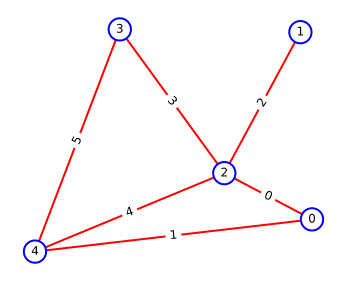

In [23]:
op.topotools.plot_tutorial(pn)

The basic premise of how OpenPNM stores topology can be stated in 1 sentence:

**The pores on either end of a throat are just another property to be stored, along with diameter, length, etc.**

In other words, referring to the above diagram, throat No. 5 has pores 3 and 4 on it's ends.  Using the spreadsheet analogy, this implies a new colunm that stores the pair of pores connected by each throat.  OpenPNM calls this property ``'throat.conns'``: 

In [24]:
print(pn['throat.conns'])

[[0 2]
 [0 4]
 [1 2]
 [2 3]
 [2 4]
 [3 4]]


Inspection of this *Nt-by-2* array shows that each row contains the pore indices corresponding to that throat.

### Sparse Adjacency Matrices

The topology storage scheme described above is actually an [adjacency matrix](http://en.wikipedia.org/wiki/Adjacency_matrix), in a [sparse storage format](http://en.wikipedia.org/wiki/Sparse_matrix) known as IJV or COO.  

An adjacency matrix is a *Np*-by-*Np* matrix with non-zero values at location (*i*, *j*) indicating that pores *i* and *j* are connected.  

An important feature of the adjacency matrix is that it is highly sparse (mostly zeros) and can be stored with a variety of [sparse storage schemes](https://docs.scipy.org/doc/scipy/reference/sparse.html) offered by Scipy.  OpenPNM stores the adjacency matrix in the 'COO' format, which essentially stores the coordinates (I,J) of the nonzero elements in an two-colume wide array.

Thus the throat property called ``'throat.conns'`` is an *Nt*-by-2 array that gives the index of the two pores on either end of a given throat.  

#### Additional Thoughts on Sparse Storage

* In pore networks there is (usually) no difference between traversing from pore *i* to pore *j* or from pore *j* to pore *i*, so a 1 is also found at location (*j*, *i*) and the matrix is symmetrical.

* Since the adjacency matrix is symmetric, it is redundant to store the entire matrix when only the upper triangular part is necessary.  The ``'throat.conns'`` array only stores the upper triangular information, and *i* is always less than *j*.

* Although this storage scheme is widely known as *IJV*, the ``scipy.sparse`` module calls this the Coordinate or *COO* storage scheme.

* Some tasks are best performed on other types of storages scheme, such as *CSR* or *LIL*.  OpenPNM converts between these internally as necessary, but users can generate a desired format using the ``create_adjacency_matrix`` method which accepts the storage type as an argument (i.e. ``'csr'``, ``'lil'``, etc).  For a discussion of sparse storage schemes and the respective merits, see this [Wikipedia article](http://en.wikipedia.org/wiki/Sparse_matrix).

### Topology Rules

The only topology definitions required by OpenPNM are:

1. A throat connects exactly two pores, no more and no less

2. Throats are non-directional, meaning that flow in either direction is equal

Other general, but non-essential rules are:

3. Pores can have an arbitrary number of throats, including zero; however, pores with zero throats lead to singular matrices and other problems so should be avoided.

4. Two pores are generally connected by no more than one throat.  It is technically possible in OpenPNM to have multiple throats between a pair of pores, but it is not rigorosly supported so unintended results may arise.



### Historical Aside
During the development of OpenPNM, it was debated whether existing Python graph theory packages (such as [graph-tool](http://graph-tool.skewed.de/) or [NetworkX](http://networkx.github.io/)) should be used to store the network topology.  It was decided that network property data should be simply stored as [Numpy ND-arrays](http://www.numpy.org/) as discussed above for the primary reason that this format makes the data storage very transparent and familiar since all engineers are used to working with arrays (i.e. vectors), and also very efficiently since this allows code vectorization.  Fortuitously, around the same time as this discussion, Scipy introduced the [compressed sparse graph library](http://docs.scipy.org/doc/scipy/reference/sparse.csgraph.html), which contains numerous graph theory algorithms that take Numpy arrays as arguments.  Therefore, OpenPNM's topology model is implemented using Numpy arrays, leveraging the ``scipy.sparse.csgraph`` library. Most importantly, this approach is perfectly in tune with the 'spreadsheet' model of data storage.